# Heads-up

In this notebook, we keep exploring
the greedy strategy. 

Differently, we give the model more
information regarding not only a node's
first order but also second order, third
order (or more) out neighbors.

Similarly, the model is given the first
order out neighbor with smallest weight
as the "ground truth"

# Some take-aways

Seems that the model has learned to be not greedy
on some graphs; since when a pure greedy strategy
coundn't even find a path, i.e., the algorithm gets
stuck in a cycle, the neural network is able to be
not so greedy and still find a path towards the goal

In [152]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import generate_low_degree_g, plot_g

In [177]:
G = generate_low_degree_g()
print(G.number_of_nodes())
print(G.number_of_edges())

20
61


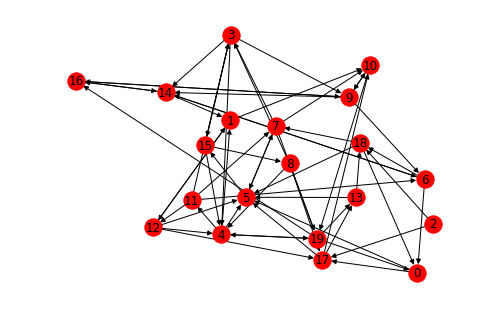

In [178]:
plot_g(G)

In [179]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

4

In [180]:
def generate_dataset(G):
    
    X, y = [], []
    
    for node in G.nodes:

        if G.out_degree(node) == 0:
            print('Node %d has 0 out degree' % node)
            continue

        init_weight_vec = np.ones((max_out_degree, (max_out_degree + 1)))

        for idx, out_edge in enumerate(G.out_edges(node)):
            out_neighbor = out_edge[1]
            init_weight_vec[idx][0] = G.get_edge_data(node, out_neighbor)['weight']
            
            for second_idx, second_order_out_edge in enumerate(G.out_edges(out_neighbor), start=1):
                init_weight_vec[idx][second_idx] = G.get_edge_data(out_neighbor, second_order_out_edge[1])['weight']

        out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
    #     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))

    #     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
        label = min(out_neighbors, key=lambda d: d[1])[1]
    #     print(label, init_weight_vec[np.argmin(init_weight_vec)])

        X.append(init_weight_vec)
        y.append(label)
    
    return np.array(X), np.array(y)

features, labels = generate_dataset(G)
print(features.shape)
print(labels.shape)

(20, 4, 5)
(20,)


In [182]:
def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

def augment_dataset(X, y=None, augmentation_1=100, augmentation_2=200):
    
    X_aug, y_aug = [], []
    indices_1 = np.arange(max_out_degree)
    indices_2 = list(range(1, 1 + max_out_degree))
    
    for _, x in enumerate(X):
        for _ in range(augmentation_1):
            np.random.shuffle(indices_1)
            
            feature_1 = x[indices_1]
            
            for _ in range(augmentation_2):

                for f_2_idx, feature_2 in enumerate(feature_1):

                    np.random.shuffle(indices_2)
                    feature_1[f_2_idx] = feature_2[[0] + indices_2]
                    X_aug.append(feature_1)
                    y_aug.append(one_hot_encode(np.argmin(feature_1, axis=0)[0]))

            
    return np.array(X_aug), np.array(y_aug)

X_aug, y_aug = augment_dataset(features, labels)
print(X_aug.shape)
print(y_aug.shape)
print(X_aug[-1])
print(y_aug[-1])

(1600000, 4, 5)
(1600000, 4)
[[ 0.05719178  0.81145912  0.62126454  1.          1.        ]
 [ 0.15902553  0.94033102  1.          1.          0.06014211]
 [ 0.78387317  0.80233105  1.          1.          0.44309984]
 [ 0.27670891  0.08026971  0.10369411  0.50007518  0.75346993]]
[ 1.  0.  0.  0.]


In [183]:
from sklearn.model_selection import train_test_split
import calendar
import time

X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, train_size=0.8, test_size=0.2, \
                                                    random_state=calendar.timegm(time.gmtime()))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1280000, 4, 5)
(1280000, 4)
(320000, 4, 5)
(320000, 4)


In [184]:
batch_size = 100

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)

In [185]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    data = mx.sym.flatten(data=data)
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [189]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

custom_metric = mx.metric.create(custom_acc)

In [190]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=2)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [10]	Speed: 120480.97 samples/sec	custom_acc=0.262727
INFO:root:Epoch[0] Batch [20]	Speed: 117897.01 samples/sec	custom_acc=0.406000
INFO:root:Epoch[0] Batch [30]	Speed: 103211.38 samples/sec	custom_acc=0.484000
INFO:root:Epoch[0] Batch [40]	Speed: 81679.11 samples/sec	custom_acc=0.591000
INFO:root:Epoch[0] Batch [50]	Speed: 81182.70 samples/sec	custom_acc=0.660000
INFO:root:Epoch[0] Batch [60]	Speed: 84467.21 samples/sec	custom_acc=0.727000
INFO:root:Epoch[0] Batch [70]	Speed: 78125.13 samples/sec	custom_acc=0.780000
INFO:root:Epoch[0] Batch [80]	Speed: 76011.31 samples/sec	custom_acc=0.787000
INFO:root:Epoch[0] Batch [90]	Speed: 78357.20 samples/sec	custom_acc=0.844000
INFO:root:Epoch[0] Batch [100]	Speed: 78033.56 samples/sec	custom_acc=0.857000
INFO:root:Epoch[0] Batch [110]	Speed: 80037.86 samples/sec	custom_acc=0.876000
INFO:root:Epoch[0] Batch [120]	Speed: 79961.57 samples/sec	custom_acc=0.903000
INFO:root:Epoch[0] Batch [130]	Speed: 78881.82 samples/sec

INFO:root:Epoch[0] Batch [1040]	Speed: 110556.80 samples/sec	custom_acc=0.985000
INFO:root:Epoch[0] Batch [1050]	Speed: 101326.38 samples/sec	custom_acc=0.983000
INFO:root:Epoch[0] Batch [1060]	Speed: 112968.76 samples/sec	custom_acc=0.992000
INFO:root:Epoch[0] Batch [1070]	Speed: 72130.29 samples/sec	custom_acc=0.986000
INFO:root:Epoch[0] Batch [1080]	Speed: 107101.37 samples/sec	custom_acc=0.984000
INFO:root:Epoch[0] Batch [1090]	Speed: 91708.84 samples/sec	custom_acc=0.966000
INFO:root:Epoch[0] Batch [1100]	Speed: 103476.19 samples/sec	custom_acc=0.966000
INFO:root:Epoch[0] Batch [1110]	Speed: 103402.21 samples/sec	custom_acc=0.966000
INFO:root:Epoch[0] Batch [1120]	Speed: 102031.33 samples/sec	custom_acc=0.958000
INFO:root:Epoch[0] Batch [1130]	Speed: 78778.11 samples/sec	custom_acc=0.958000
INFO:root:Epoch[0] Batch [1140]	Speed: 99981.03 samples/sec	custom_acc=0.972000
INFO:root:Epoch[0] Batch [1150]	Speed: 105384.52 samples/sec	custom_acc=0.980000
INFO:root:Epoch[0] Batch [1160]	

INFO:root:Epoch[0] Batch [2060]	Speed: 122129.81 samples/sec	custom_acc=0.993000
INFO:root:Epoch[0] Batch [2070]	Speed: 122687.10 samples/sec	custom_acc=0.988000
INFO:root:Epoch[0] Batch [2080]	Speed: 117827.46 samples/sec	custom_acc=0.990000
INFO:root:Epoch[0] Batch [2090]	Speed: 118637.33 samples/sec	custom_acc=0.988000
INFO:root:Epoch[0] Batch [2100]	Speed: 122472.16 samples/sec	custom_acc=0.988000
INFO:root:Epoch[0] Batch [2110]	Speed: 114940.78 samples/sec	custom_acc=0.990000
INFO:root:Epoch[0] Batch [2120]	Speed: 115845.55 samples/sec	custom_acc=0.987000
INFO:root:Epoch[0] Batch [2130]	Speed: 108237.31 samples/sec	custom_acc=0.977000
INFO:root:Epoch[0] Batch [2140]	Speed: 118664.18 samples/sec	custom_acc=0.986000
INFO:root:Epoch[0] Batch [2150]	Speed: 122204.53 samples/sec	custom_acc=0.992000
INFO:root:Epoch[0] Batch [2160]	Speed: 115006.96 samples/sec	custom_acc=0.986000
INFO:root:Epoch[0] Batch [2170]	Speed: 115262.96 samples/sec	custom_acc=0.991000
INFO:root:Epoch[0] Batch [21

INFO:root:Epoch[0] Batch [3080]	Speed: 97265.99 samples/sec	custom_acc=0.990000
INFO:root:Epoch[0] Batch [3090]	Speed: 114824.35 samples/sec	custom_acc=0.994000
INFO:root:Epoch[0] Batch [3100]	Speed: 120758.47 samples/sec	custom_acc=0.990000
INFO:root:Epoch[0] Batch [3110]	Speed: 114348.53 samples/sec	custom_acc=0.997000
INFO:root:Epoch[0] Batch [3120]	Speed: 115168.02 samples/sec	custom_acc=0.992000
INFO:root:Epoch[0] Batch [3130]	Speed: 118399.55 samples/sec	custom_acc=0.989000
INFO:root:Epoch[0] Batch [3140]	Speed: 107759.01 samples/sec	custom_acc=0.997000
INFO:root:Epoch[0] Batch [3150]	Speed: 111919.74 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [3160]	Speed: 123623.67 samples/sec	custom_acc=0.992000
INFO:root:Epoch[0] Batch [3170]	Speed: 115631.57 samples/sec	custom_acc=0.993000
INFO:root:Epoch[0] Batch [3180]	Speed: 121938.08 samples/sec	custom_acc=0.995000
INFO:root:Epoch[0] Batch [3190]	Speed: 124485.92 samples/sec	custom_acc=0.994000
INFO:root:Epoch[0] Batch [320

INFO:root:Epoch[0] Batch [4100]	Speed: 114969.14 samples/sec	custom_acc=0.988000
INFO:root:Epoch[0] Batch [4110]	Speed: 120671.62 samples/sec	custom_acc=0.992000
INFO:root:Epoch[0] Batch [4120]	Speed: 121475.44 samples/sec	custom_acc=0.995000
INFO:root:Epoch[0] Batch [4130]	Speed: 122279.35 samples/sec	custom_acc=0.992000
INFO:root:Epoch[0] Batch [4140]	Speed: 116440.52 samples/sec	custom_acc=0.998000
INFO:root:Epoch[0] Batch [4150]	Speed: 117688.60 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [4160]	Speed: 114261.31 samples/sec	custom_acc=0.995000
INFO:root:Epoch[0] Batch [4170]	Speed: 117316.63 samples/sec	custom_acc=0.985000
INFO:root:Epoch[0] Batch [4180]	Speed: 122579.54 samples/sec	custom_acc=0.993000
INFO:root:Epoch[0] Batch [4190]	Speed: 101677.63 samples/sec	custom_acc=0.991000
INFO:root:Epoch[0] Batch [4200]	Speed: 119075.18 samples/sec	custom_acc=0.995000
INFO:root:Epoch[0] Batch [4210]	Speed: 117152.78 samples/sec	custom_acc=0.992000
INFO:root:Epoch[0] Batch [42

INFO:root:Epoch[0] Batch [5120]	Speed: 120713.29 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [5130]	Speed: 120657.73 samples/sec	custom_acc=0.987000
INFO:root:Epoch[0] Batch [5140]	Speed: 122697.87 samples/sec	custom_acc=0.995000
INFO:root:Epoch[0] Batch [5150]	Speed: 125709.70 samples/sec	custom_acc=0.998000
INFO:root:Epoch[0] Batch [5160]	Speed: 121138.63 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [5170]	Speed: 121019.79 samples/sec	custom_acc=0.997000
INFO:root:Epoch[0] Batch [5180]	Speed: 118566.90 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [5190]	Speed: 125439.00 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [5200]	Speed: 117494.09 samples/sec	custom_acc=0.993000
INFO:root:Epoch[0] Batch [5210]	Speed: 123303.86 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [5220]	Speed: 116741.93 samples/sec	custom_acc=0.994000
INFO:root:Epoch[0] Batch [5230]	Speed: 115472.40 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [52

INFO:root:Epoch[0] Batch [6140]	Speed: 61482.03 samples/sec	custom_acc=0.995000
INFO:root:Epoch[0] Batch [6150]	Speed: 64345.61 samples/sec	custom_acc=0.998000
INFO:root:Epoch[0] Batch [6160]	Speed: 75278.71 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [6170]	Speed: 63630.08 samples/sec	custom_acc=0.998000
INFO:root:Epoch[0] Batch [6180]	Speed: 70373.05 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [6190]	Speed: 70151.77 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [6200]	Speed: 70422.67 samples/sec	custom_acc=0.994000
INFO:root:Epoch[0] Batch [6210]	Speed: 65656.03 samples/sec	custom_acc=0.997000
INFO:root:Epoch[0] Batch [6220]	Speed: 58336.87 samples/sec	custom_acc=0.993000
INFO:root:Epoch[0] Batch [6230]	Speed: 71295.33 samples/sec	custom_acc=0.995000
INFO:root:Epoch[0] Batch [6240]	Speed: 74867.54 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [6250]	Speed: 62050.51 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [6260]	Speed: 7

INFO:root:Epoch[0] Batch [7170]	Speed: 65116.81 samples/sec	custom_acc=0.997000
INFO:root:Epoch[0] Batch [7180]	Speed: 65599.55 samples/sec	custom_acc=0.998000
INFO:root:Epoch[0] Batch [7190]	Speed: 96190.81 samples/sec	custom_acc=0.998000
INFO:root:Epoch[0] Batch [7200]	Speed: 69036.36 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [7210]	Speed: 74603.87 samples/sec	custom_acc=0.991000
INFO:root:Epoch[0] Batch [7220]	Speed: 64968.54 samples/sec	custom_acc=0.993000
INFO:root:Epoch[0] Batch [7230]	Speed: 59790.51 samples/sec	custom_acc=0.987000
INFO:root:Epoch[0] Batch [7240]	Speed: 56675.95 samples/sec	custom_acc=0.994000
INFO:root:Epoch[0] Batch [7250]	Speed: 64048.87 samples/sec	custom_acc=0.997000
INFO:root:Epoch[0] Batch [7260]	Speed: 60346.22 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [7270]	Speed: 75170.78 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [7280]	Speed: 72516.88 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [7290]	Speed: 5

INFO:root:Epoch[0] Batch [8190]	Speed: 119075.18 samples/sec	custom_acc=0.997000
INFO:root:Epoch[0] Batch [8200]	Speed: 111172.18 samples/sec	custom_acc=0.998000
INFO:root:Epoch[0] Batch [8210]	Speed: 110594.70 samples/sec	custom_acc=0.992000
INFO:root:Epoch[0] Batch [8220]	Speed: 113830.27 samples/sec	custom_acc=0.992000
INFO:root:Epoch[0] Batch [8230]	Speed: 115660.27 samples/sec	custom_acc=0.977000
INFO:root:Epoch[0] Batch [8240]	Speed: 122218.78 samples/sec	custom_acc=0.978000
INFO:root:Epoch[0] Batch [8250]	Speed: 115300.99 samples/sec	custom_acc=0.992000
INFO:root:Epoch[0] Batch [8260]	Speed: 117523.72 samples/sec	custom_acc=0.991000
INFO:root:Epoch[0] Batch [8270]	Speed: 99235.89 samples/sec	custom_acc=0.986000
INFO:root:Epoch[0] Batch [8280]	Speed: 119803.03 samples/sec	custom_acc=0.993000
INFO:root:Epoch[0] Batch [8290]	Speed: 111307.89 samples/sec	custom_acc=0.994000
INFO:root:Epoch[0] Batch [8300]	Speed: 109792.79 samples/sec	custom_acc=0.997000
INFO:root:Epoch[0] Batch [831

INFO:root:Epoch[0] Batch [9210]	Speed: 110182.15 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [9220]	Speed: 118540.09 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [9230]	Speed: 115701.75 samples/sec	custom_acc=0.997000
INFO:root:Epoch[0] Batch [9240]	Speed: 117136.43 samples/sec	custom_acc=0.996000
INFO:root:Epoch[0] Batch [9250]	Speed: 115685.79 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [9260]	Speed: 113725.33 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [9270]	Speed: 113341.19 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [9280]	Speed: 115714.51 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [9290]	Speed: 111595.16 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [9300]	Speed: 114482.74 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [9310]	Speed: 116185.71 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [9320]	Speed: 116852.51 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [93

INFO:root:Epoch[0] Batch [10230]	Speed: 123776.90 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [10240]	Speed: 123000.12 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [10250]	Speed: 120280.58 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [10260]	Speed: 109818.66 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [10270]	Speed: 119088.70 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [10280]	Speed: 121464.89 samples/sec	custom_acc=0.998000
INFO:root:Epoch[0] Batch [10290]	Speed: 116021.80 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [10300]	Speed: 118950.23 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [10310]	Speed: 113494.53 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [10320]	Speed: 105586.14 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [10330]	Speed: 120901.19 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [10340]	Speed: 116047.48 samples/sec	custom_acc=1.000000
INFO:root:Epoch[

INFO:root:Epoch[0] Batch [11240]	Speed: 124036.79 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [11250]	Speed: 122186.73 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [11260]	Speed: 118146.08 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [11270]	Speed: 126102.76 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [11280]	Speed: 118637.33 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [11290]	Speed: 89348.87 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [11300]	Speed: 115446.97 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [11310]	Speed: 118540.09 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [11320]	Speed: 113753.09 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [11330]	Speed: 119615.11 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [11340]	Speed: 125992.91 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [11350]	Speed: 105687.24 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0

INFO:root:Epoch[0] Batch [12250]	Speed: 116511.68 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [12260]	Speed: 117054.70 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [12270]	Speed: 118990.72 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [12280]	Speed: 60539.59 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [12290]	Speed: 49868.07 samples/sec	custom_acc=0.998000
INFO:root:Epoch[0] Batch [12300]	Speed: 108506.12 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [12310]	Speed: 55595.67 samples/sec	custom_acc=0.999000
INFO:root:Epoch[0] Batch [12320]	Speed: 103896.56 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [12330]	Speed: 112880.59 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [12340]	Speed: 118553.49 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [12350]	Speed: 121166.63 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] Batch [12360]	Speed: 114314.25 samples/sec	custom_acc=1.000000
INFO:root:Epoch[0] 

INFO:root:Epoch[1] Batch [460]	Speed: 115765.62 samples/sec	custom_acc=0.991000
INFO:root:Epoch[1] Batch [470]	Speed: 94055.34 samples/sec	custom_acc=0.986000
INFO:root:Epoch[1] Batch [480]	Speed: 122640.47 samples/sec	custom_acc=0.981000
INFO:root:Epoch[1] Batch [490]	Speed: 114298.67 samples/sec	custom_acc=0.992000
INFO:root:Epoch[1] Batch [500]	Speed: 117428.30 samples/sec	custom_acc=0.997000
INFO:root:Epoch[1] Batch [510]	Speed: 120817.61 samples/sec	custom_acc=0.999000
INFO:root:Epoch[1] Batch [520]	Speed: 117316.63 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [530]	Speed: 118637.33 samples/sec	custom_acc=0.999000
INFO:root:Epoch[1] Batch [540]	Speed: 112484.02 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [550]	Speed: 114523.37 samples/sec	custom_acc=0.999000
INFO:root:Epoch[1] Batch [560]	Speed: 103809.13 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [570]	Speed: 108214.97 samples/sec	custom_acc=0.999000
INFO:root:Epoch[1] Batch [580]	Speed: 120

INFO:root:Epoch[1] Batch [1490]	Speed: 120977.91 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1500]	Speed: 124626.47 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1510]	Speed: 114799.21 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1520]	Speed: 120730.66 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1530]	Speed: 115073.23 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1540]	Speed: 118849.11 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1550]	Speed: 120439.45 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1560]	Speed: 121849.51 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1570]	Speed: 114573.43 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1580]	Speed: 120263.33 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1590]	Speed: 118289.36 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [1600]	Speed: 119034.62 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [16

INFO:root:Epoch[1] Batch [2510]	Speed: 45741.41 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [2520]	Speed: 107205.40 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [2530]	Speed: 37391.72 samples/sec	custom_acc=0.997000
INFO:root:Epoch[1] Batch [2540]	Speed: 68040.75 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [2550]	Speed: 96917.62 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [2560]	Speed: 111310.85 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [2570]	Speed: 82081.92 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [2580]	Speed: 103348.71 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [2590]	Speed: 114548.39 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [2600]	Speed: 83215.36 samples/sec	custom_acc=0.999000
INFO:root:Epoch[1] Batch [2610]	Speed: 100411.86 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [2620]	Speed: 85317.71 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [2630]	Spe

INFO:root:Epoch[1] Batch [3530]	Speed: 112219.18 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3540]	Speed: 113237.15 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3550]	Speed: 116102.09 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3560]	Speed: 116127.80 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3570]	Speed: 112474.97 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3580]	Speed: 115035.35 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3590]	Speed: 109397.60 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3600]	Speed: 67087.40 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3610]	Speed: 119803.03 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3620]	Speed: 115010.12 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3630]	Speed: 121609.28 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [3640]	Speed: 111544.71 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [365

INFO:root:Epoch[1] Batch [4550]	Speed: 73986.66 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4560]	Speed: 57833.32 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4570]	Speed: 76756.90 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4580]	Speed: 46131.81 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4590]	Speed: 62103.79 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4600]	Speed: 66168.74 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4610]	Speed: 53092.46 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4620]	Speed: 96776.74 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4630]	Speed: 56783.38 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4640]	Speed: 70209.31 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4650]	Speed: 72944.42 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4660]	Speed: 48981.14 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [4670]	Speed: 6

INFO:root:Epoch[1] Batch [5570]	Speed: 114273.76 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5580]	Speed: 111036.80 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5590]	Speed: 115823.16 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5600]	Speed: 121817.66 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5610]	Speed: 112462.90 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5620]	Speed: 110658.89 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5630]	Speed: 110790.43 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5640]	Speed: 113713.00 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5650]	Speed: 97532.88 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5660]	Speed: 118189.36 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5670]	Speed: 99473.59 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5680]	Speed: 118764.98 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [5690

INFO:root:Epoch[1] Batch [6590]	Speed: 114105.88 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6600]	Speed: 115101.65 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6610]	Speed: 115421.56 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6620]	Speed: 119933.20 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6630]	Speed: 112804.69 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6640]	Speed: 98901.27 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6650]	Speed: 114679.94 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6660]	Speed: 115807.17 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6670]	Speed: 120890.73 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6680]	Speed: 113008.33 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6690]	Speed: 116943.74 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [6700]	Speed: 116878.56 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [671

INFO:root:Epoch[1] Batch [7610]	Speed: 117731.54 samples/sec	custom_acc=0.998000
INFO:root:Epoch[1] Batch [7620]	Speed: 116304.91 samples/sec	custom_acc=0.982000
INFO:root:Epoch[1] Batch [7630]	Speed: 122985.69 samples/sec	custom_acc=0.968000
INFO:root:Epoch[1] Batch [7640]	Speed: 67531.34 samples/sec	custom_acc=0.952000
INFO:root:Epoch[1] Batch [7650]	Speed: 102133.20 samples/sec	custom_acc=0.969000
INFO:root:Epoch[1] Batch [7660]	Speed: 61185.16 samples/sec	custom_acc=0.980000
INFO:root:Epoch[1] Batch [7670]	Speed: 33233.79 samples/sec	custom_acc=0.985000
INFO:root:Epoch[1] Batch [7680]	Speed: 73029.51 samples/sec	custom_acc=0.985000
INFO:root:Epoch[1] Batch [7690]	Speed: 97236.68 samples/sec	custom_acc=0.992000
INFO:root:Epoch[1] Batch [7700]	Speed: 84467.21 samples/sec	custom_acc=0.991000
INFO:root:Epoch[1] Batch [7710]	Speed: 104865.46 samples/sec	custom_acc=0.999000
INFO:root:Epoch[1] Batch [7720]	Speed: 109529.01 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [7730]	Sp

INFO:root:Epoch[1] Batch [8630]	Speed: 107584.88 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8640]	Speed: 114931.33 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8650]	Speed: 113586.74 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8660]	Speed: 110901.75 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8670]	Speed: 116198.58 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8680]	Speed: 116482.56 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8690]	Speed: 118049.65 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8700]	Speed: 113932.31 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8710]	Speed: 111075.02 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8720]	Speed: 118748.17 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8730]	Speed: 114890.40 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [8740]	Speed: 117675.39 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [87

INFO:root:Epoch[1] Batch [9650]	Speed: 113660.61 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9660]	Speed: 110072.27 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9670]	Speed: 110312.56 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9680]	Speed: 113316.69 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9690]	Speed: 117672.09 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9700]	Speed: 120876.80 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9710]	Speed: 107098.64 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9720]	Speed: 121387.55 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9730]	Speed: 122550.88 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9740]	Speed: 120859.38 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9750]	Speed: 123561.76 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [9760]	Speed: 119502.65 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [97

INFO:root:Epoch[1] Batch [10660]	Speed: 120946.51 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10670]	Speed: 122640.47 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10680]	Speed: 115756.03 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10690]	Speed: 121401.60 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10700]	Speed: 115701.75 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10710]	Speed: 114639.19 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10720]	Speed: 124257.27 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10730]	Speed: 116647.77 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10740]	Speed: 84817.37 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10750]	Speed: 116076.38 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10760]	Speed: 122129.81 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [10770]	Speed: 116660.75 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1

INFO:root:Epoch[1] Batch [11670]	Speed: 71148.99 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11680]	Speed: 76305.86 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11690]	Speed: 72055.94 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11700]	Speed: 88082.32 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11710]	Speed: 81036.83 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11720]	Speed: 69289.54 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11730]	Speed: 76150.69 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11740]	Speed: 74839.48 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11750]	Speed: 74448.93 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11760]	Speed: 71245.67 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11770]	Speed: 76692.34 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11780]	Speed: 44078.19 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [11

INFO:root:Epoch[1] Batch [12680]	Speed: 124301.46 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12690]	Speed: 122910.01 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12700]	Speed: 117688.60 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12710]	Speed: 86021.12 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12720]	Speed: 118963.72 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12730]	Speed: 115711.32 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12740]	Speed: 116534.34 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12750]	Speed: 105141.48 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12760]	Speed: 80971.12 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12770]	Speed: 88738.29 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12780]	Speed: 45306.11 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Batch [12790]	Speed: 65283.03 samples/sec	custom_acc=1.000000
INFO:root:Epoch[1] Tr

In [191]:
pred_test = np.argmax(model.predict(val_iter).asnumpy(), axis=1)
print('Acc on test set %f' % accuracy_score(np.argmax(y_test, axis=1), pred_test))

Acc on test set 1.000000


In [192]:
def infer_next_node(G, cur_node):
#     print("In infer_next_node")
    return min(map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node)), key=lambda d:d[1])

def nn_infer_next_node(G, cur_node, model):
#     print("In nn_infer_next_node")

    init_weight_vec = np.ones((max_out_degree, (max_out_degree + 1)))

    for idx, out_edge in enumerate(G.out_edges(cur_node)):
        out_neighbor = out_edge[1]
        init_weight_vec[idx][0] = G.get_edge_data(cur_node, out_neighbor)['weight']

        for second_idx, second_order_out_edge in enumerate(G.out_edges(out_neighbor), start=1):
            init_weight_vec[idx][second_idx] = G.get_edge_data(out_neighbor, second_order_out_edge[1])['weight']
            
#     print init_weight_vec
#     print np.argmin(init_weight_vec, axis=0)[0]
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node))
    
    pred_idx = np.argmax(model.predict(mx.io.NDArrayIter(np.array([init_weight_vec]), np.array([0]))).asnumpy()[0])
#     print pred_idx
    return out_neighbors[pred_idx]

def greedy_path_finder(G, src, dst, use_nn=False, model=None):
    
    path = [src]
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, cur_node, model) if use_nn else infer_next_node(G, cur_node)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        cur_node = next_node

In [194]:
src, dst = 19, 2

print greedy_path_finder(G, src, dst)
print greedy_path_finder(G, src, dst, use_nn=True, model=model)
# print nx.single_source_dijkstra(G, src, dst)[1], nx.single_source_dijkstra(G, src, dst)[0]

([19, 13, 5, 7, 10, 19, 13, 5, 7, 10, 19, 13, 5, 7, 10, 19, 13, 5, 7, 10], 7.02897596404593, False)
([19, 13, 5, 7, 10, 19, 13, 5, 7, 10, 19, 13, 5, 7, 10, 19, 13, 5, 7, 10], 7.02897596404593, False)


In [201]:
def check_greedy_path_finder_acc(G, model):
    
    basic_stat = [0, 0, 0, 0]
    extra_stat = {'eq':0, 'path_more':0, 'nn_path_more':0}
    
    for src in G.nodes:
        for dst in G.nodes:
            
            if src == dst:
                continue
            
            path, _, found = greedy_path_finder(G, src, dst)
            nn_path, _, nn_found = greedy_path_finder(G, src, dst, use_nn=True, model=model)
            
            if found == nn_found and found == True:
                basic_stat[0] += 1
                
                if path == nn_path:
                    extra_stat['eq'] += 1
                elif len(path) < len(nn_path):
                    extra_stat['nn_path_more'] += 1
                elif len(path) > len(nn_path):
                    extra_stat['path_more'] += 1
                else:
#                     assert False
                    print 'greedy_path_finder', path
                    print 'nn_greedy_path_finder', nn_path
                
            elif found == nn_found and found == False:
                basic_stat[1] += 1
            elif found == True and nn_found == False:
                basic_stat[2] += 1
            elif found == False and nn_found == True:
                print src, dst
                print 'greedy_path_finder', path
                print 'nn_greedy_path_finder', nn_path
                basic_stat[3] += 1
            else:
                assert False
    
    return basic_stat, extra_stat

In [211]:
G_1 = generate_low_degree_g()
print(G_1.number_of_nodes())
print(G_1.number_of_edges())
basic_stat, extra_stat = check_greedy_path_finder_acc(G_1, model)

20
66
5 0
greedy_path_finder [5, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10]
nn_greedy_path_finder [5, 9, 14, 0]
5 1
greedy_path_finder [5, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10]
nn_greedy_path_finder [5, 9, 14, 0, 1]
5 7
greedy_path_finder [5, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10]
nn_greedy_path_finder [5, 9, 14, 0, 1, 7]
5 9
greedy_path_finder [5, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10]
nn_greedy_path_finder [5, 9]
5 14
greedy_path_finder [5, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10, 2, 17, 18, 10]
nn_greedy_path_finder [5, 9, 14]


In [212]:
print(map(lambda d: float(d)/sum(basic_stat), basic_stat))
print(extra_stat)

[0.18947368421052632, 0.7868421052631579, 0.010526315789473684, 0.013157894736842105]
{'path_more': 0, 'eq': 72, 'nn_path_more': 0}


In [66]:
def print_stat(basic_stat, extra_stat):
    basic_stat = map(lambda d: float(d)/sum(basic_stat), basic_stat)
    pass
    